# Tutorial: Removing Cross-Swath Bias in `ssha_karin_2`

---
**Author**: Jinbo Wang   
**Date**: 9/7/2023  
**Revison History**

* 5/29/2024: add direct s3 access and earthaccess

---
⚠️ **Disclaimer: Preliminary** ⚠️

_This project is currently in the process of reprocessing the data. The SWOT data should not be used for scientific analyses. The code provided here is aimed at demonstrating basic techniques for data access, processing, and visualization._

### Prerequisites
Before proceeding with this tutorial, you'll need to download the SWOT KaRIn Expert product. This code is explicit on visualization. Major analysis is done by the routine `swot_ssh_utils.fit_bias`. 

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import sys
sys.path.append('/Users/MikeyD/Documents/Grad School/ARCTERX/Leg1/SWOT/SWOT-OpenToolkit/src/') # this is the directiory where swot_ssh_utils.py is located. 
import swot_ssh_utils as swot
from cartopy import crs as ccrs
from glob import glob
import xarray as xr
from IPython.display import HTML
import pandas as pd
%matplotlib widget
#uncomment the following line to install earthaccess if it is not yet installed
# !pip install earthaccess

def load_and_plot_ssha_data(data,plot_type='error'):
    """
    data is a swot.SSH_L2 instance with Expert input
    
    Returns:
    None
    """

    # Preprocess data
    ssha = data.Expert.ssha_karin_2
    flag = data.Expert.ancillary_surface_classification_flag
    ssha = np.where(flag == 0, ssha, np.nan)
    ssha_err = data.Expert.ssh_karin_uncert
    ssha_err = np.where(flag==0,ssha_err,np.nan)

    lon = data.Expert.longitude.values
    lat = data.Expert.latitude.values
    distance = data.Expert.cross_track_distance.values
    date = data.Expert.time.mean().values
   
    
     

    # plot error on ax[0]
    if plot_type == 'error':
        # Create plots
        fig, ax = plt.subplots(
            figsize=(8, 6),
            ncols=2,
            nrows=1,
            sharex=True,
            sharey=True,
            subplot_kw=dict(projection=ccrs.PlateCarree())
        )
        swot.plot_a_segment(ax[0],lon,lat,ssha_err,title='SSHA_KaRIn_2 error',vmin=0,vmax=0.005)
        ax[0].set_xlim([130,135])
    
    # plot tide on ax[0]
    if plot_type == 'tide':
        # Create plots
        fig, ax = plt.subplots(
            figsize=(8, 6),
            ncols=1,
            nrows=2,
            subplot_kw=dict(projection=ccrs.PlateCarree())
        )
        tide_ds = xr.open_dataset('/Users/MikeyD/Documents/Grad School/ARCTERX/Leg1/SWOT/h028b.nc')
        ax[0].plot(tide_ds.time,tide_ds.sea_level.isel(record_id=0))

        startTime = np.datetime64(date) - np.timedelta64(4,'D') # +/- 4 days from date
        endTime = np.datetime64(date) + np.timedelta64(4,'D')

        ax[0].set_xlim([startTime,endTime])
        ax[0].axvline(date)


    
    # Plot original data
    # swot.plot_a_segment(ax[0], lon, lat, ssha, title='SSHA_KaRIn_2 original', vmin=-5, vmax=5)

    
    # Plot Error 

    # Bias correction (optional)
    ssha_1 = swot.fit_bias(
        ssha, distance,
        order=3, # polynomial to fit
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )
    
    # mask out data in nadir and outside of 60km swath width
    distance = np.nanmean(distance, axis=0 )
    msk = (np.abs(distance) < 60e3) & (np.abs(distance) > 10e3)
    lon[:, ~msk] = np.nan
    lat[:, ~msk] = np.nan
    ssha_1[:, ~msk] = np.nan

    # Plot bias corrected data
    swot.plot_a_segment(ax[1], lon, lat, ssha_1, title='SSHA_KaRIn_2 bias corrected', vmin=-0.1, vmax=0.1)

    

    ax[1].set_xlim([130,135])
    # Save and display plot
    plt.tight_layout()
    fig.suptitle(str(date))
    #plt.savefig('../media/figures/ssha_karin_2_california.png', dpi=100)

In [10]:
SWOT_folder = '/Users/MikeyD/Documents/Grad School/ARCTERX/Leg2Cruise/SWOT'
Jan16File = 'SWOT_L2_LR_SSH_Expert_027_088_20250116T194144_20250116T203229_PIC2_01.nc'
file = Jan16File
ds = xr.open_dataset(SWOT_folder+'/'+ file)
# display(ds)

In [11]:
lat_bounds = [18, 22]
data=swot.SSH_L2() 
data.load_data(SWOT_folder+'/'+file,
              lat_bounds=lat_bounds)
display(data.Expert)

<xarray.Dataset> Size: 9MB
Dimensions:                                (num_lines: 225, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 2kB 22.0 ... 1...
    longitude_nadir                        (num_lines) float64 2kB 130.5 ... ...
    latitude                               (num_lines, num_pixels) float64 124kB ...
    longitude                              (num_lines, num_pixels) float64 124kB ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 2kB ...
    time_tai                               (num_lines) datetime64[ns] 2kB ...
    ssh_karin                              (num_lines, num_pixels) float64 124kB ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 124kB ...
    ssh_karin_uncert                       (num_lines, num_pixels) float64 124kB ...
    ssha_karin                             (num_lines, num_pixels) float64 124kB ...
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 62kB ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 62kB ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 62kB ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 62kB ...
    volumetric_correlation                 (num_lines, num_pixels) float64 124kB ...
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 124kB ...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2025-01-18T22:20:11Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       63.643283477283894
    ssha_variance:                                 0.6505530488842642
    references:                                    V1.3
    equator_longitude:                             133.95

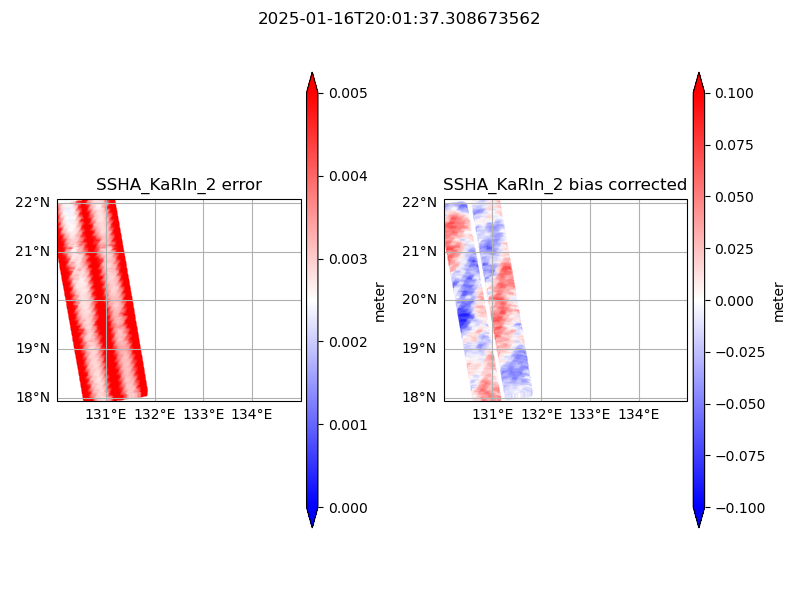

In [12]:
load_and_plot_ssha_data(data)